In the V5 runs, we compare different model dimensionality and interface representation. 

TODO:
- Unit test the updated Ellipse dataset class
- Re-run v5 experiments with no patch-based decoding
- Add surface visualisation output for v5 experiments

- To make this a fair test, all results need to be converted back to heaviside representation before computing metrics
- Check whether the ellipse dataset has been implemented correctly using some unit tests?
- Implement patch-based decoding, and then compute all metrics on entire volumes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import json

In [2]:
base_output_dir = pathlib.Path('./../output/lassen')
files = list(base_output_dir.glob('interfacial_ae_v5_*'))
len(files)

9

In [3]:
def read_loss_curve_from_file(outdir):
    loss_path = outdir / 'loss_history.json'
    with open(loss_path) as f:
        loss_curve = json.load(f)
    return loss_curve

In [4]:
name_to_loss = {}

for f in files:
    try:
        name_to_loss[f.name] = read_loss_curve_from_file(f)
        print(f'Read {f.name}')
    except:
        print(f'Error reading {f.name}')

Read interfacial_ae_v5_run_02_interfacerepresentationtanh_epsilon003125
Read interfacial_ae_v5_run_07_interfacerepresentationsdfapprox_epsilon0015625
Read interfacial_ae_v5_run_08_interfacerepresentationsdfapprox_epsilon003125
Read interfacial_ae_v5_run_05_interfacerepresentationsdfexact_epsilon003125
Read interfacial_ae_v5_run_06_interfacerepresentationsdfapprox_epsilon00078125
Read interfacial_ae_v5_run_01_interfacerepresentationtanh_epsilon0015625
Read interfacial_ae_v5_run_00_interfacerepresentationtanh_epsilon00078125
Read interfacial_ae_v5_run_03_interfacerepresentationsdfexact_epsilon00078125
Read interfacial_ae_v5_run_04_interfacerepresentationsdfexact_epsilon0015625


In [6]:
# First, let's just compare successful runs and failed runs in a binary table
# We also need to extract dimmults and zchannels
# e.g. vae_v103_run_07_dimmults12488_zchannels4

def extract_interface_representation(name):
    return name.split('_')[-2][23:]

def extract_dim(name):
    return 32
    #return int(name.split('_')[-3][3:])

def extract_dimmults(name):
    return int(name.split('_')[-2][8:])

def extract_z_channels(name):
    return int(name.split('_')[-1][9:])

def extract_batch_size(name):
    return int(name.split('_')[-1][9:])

def extract_patch_size(name):
    return int(name.split('_')[-3][-2:])

def read_compression_ratio(outdir):
    # run_info.json contains: {"latent_num_pixels": 32768, "physical_num_pixels": 32768, "compression_ratio": 1.0}
    run_info_path = outdir / 'run_info.json'
    with open(run_info_path) as f:
        run_info = json.load(f)
    return run_info['compression_ratio']

def parse_time_from_log_line(line: str):
    # E.g. 2024-12-19 01:12:34,403 - conv_ae_3d.trainer_vae - INFO: [Accelerate device cuda:0] Training complete!
    parts = line.split()
    time_str = parts[0] + ' ' + parts[1]
    time_obj = pd.to_datetime(time_str)
    return time_obj

def extract_wall_time(outdir):
    output_log_path = outdir / 'output.log'
    with open(output_log_path) as f:
        lines = f.readlines()
        first_line = lines[0]
        last_line = lines[-1]
        start_datetime = parse_time_from_log_line(first_line)
        end_datetime = parse_time_from_log_line(last_line)

        run_time_hrs = (end_datetime - start_datetime).total_seconds() / 3600

    return run_time_hrs

success_rows = []
for f in files:
    dim = extract_dim(f.name)
    interface_rep = extract_interface_representation(f.name)
    wall_time = extract_wall_time(f)
    success_rows.append(
        {
            'Name': f.name,
            #'dim': dim,
            'interface_rep': interface_rep,
            'wall time (hrs)': wall_time,
            'Success': f.name in name_to_loss
        }
    )

df = pd.DataFrame(success_rows)
df
    

,Name,interface_rep,wall time (hrs),Success
0,interfacial_ae_v5_run_02_interfacerepresentati...,tanh,1.886667,True
1,interfacial_ae_v5_run_07_interfacerepresentati...,sdfapprox,1.868333,True
2,interfacial_ae_v5_run_08_interfacerepresentati...,sdfapprox,1.869167,True
3,interfacial_ae_v5_run_05_interfacerepresentati...,sdfexact,1.891389,True
4,interfacial_ae_v5_run_06_interfacerepresentati...,sdfapprox,1.863333,True
5,interfacial_ae_v5_run_01_interfacerepresentati...,tanh,1.877500,True
6,interfacial_ae_v5_run_00_interfacerepresentati...,tanh,1.890556,True
7,interfacial_ae_v5_run_03_interfacerepresentati...,sdfexact,1.887778,True
8,interfacial_ae_v5_run_04_interfacerepresentati...,sdfexact,1.877778,True


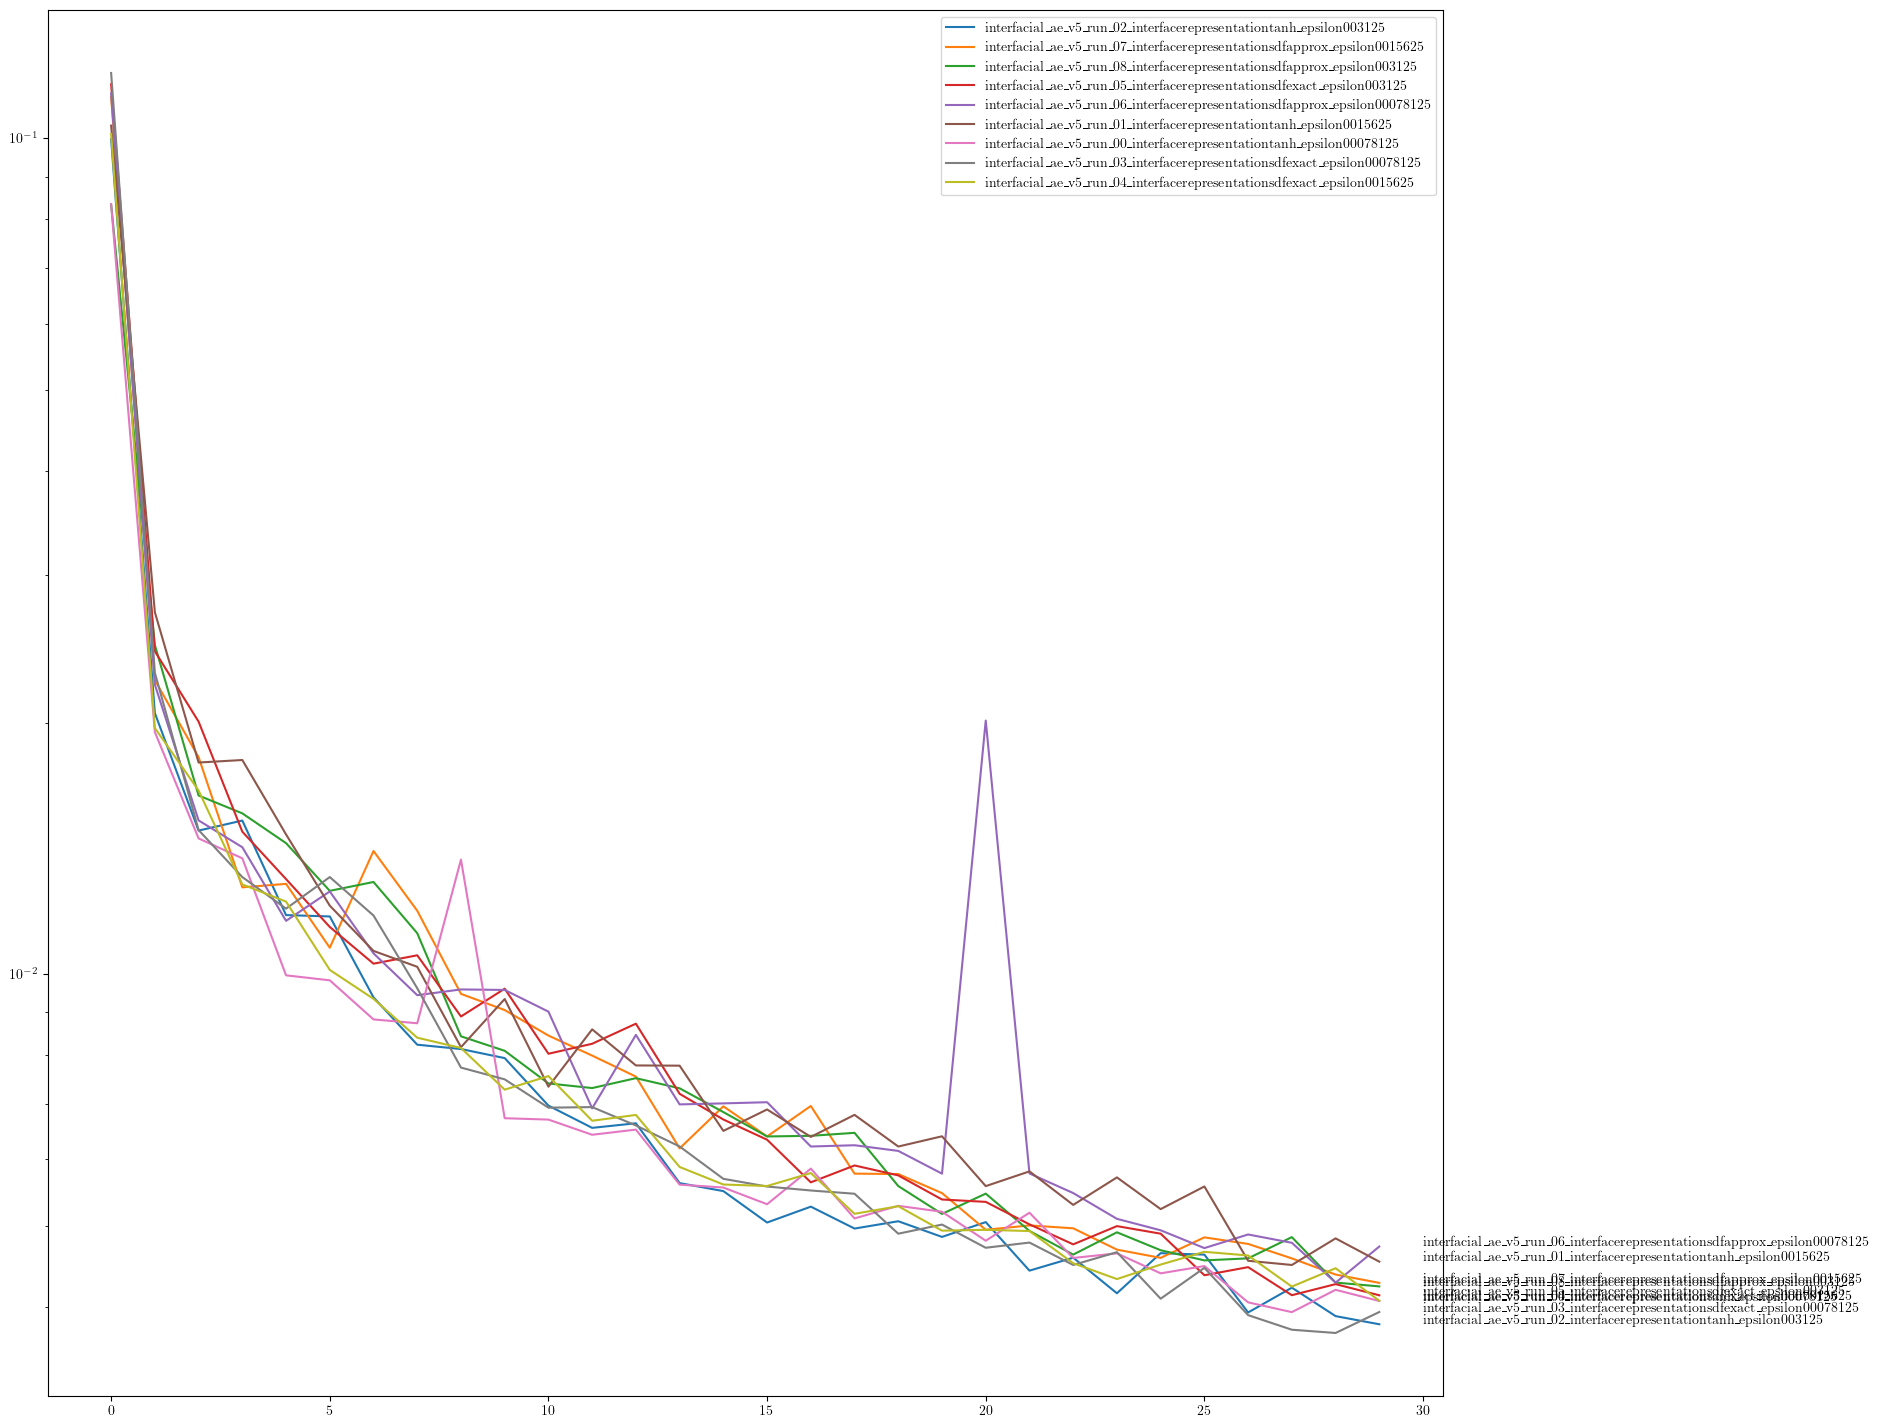

In [7]:
# Plot all loss curves on one big axis
fig, ax = plt.subplots(figsize=(18, 18))
loss_component = 'Total'
for name, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=name)
    
    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], name)
ax.legend()
ax.set_yscale('log')
plt.show()

In [ ]:
#

In [8]:

name_to_compression_ratio = {}
for f in files:
    try:
        name_to_compression_ratio[f.name] = read_compression_ratio(f)
    except:
        print(f'Error reading {f.name}')
        
name_to_compression_ratio

{'interfacial_ae_v5_run_02_interfacerepresentationtanh_epsilon003125': 128.0,
 'interfacial_ae_v5_run_07_interfacerepresentationsdfapprox_epsilon0015625': 128.0,
 'interfacial_ae_v5_run_08_interfacerepresentationsdfapprox_epsilon003125': 128.0,
 'interfacial_ae_v5_run_05_interfacerepresentationsdfexact_epsilon003125': 128.0,
 'interfacial_ae_v5_run_06_interfacerepresentationsdfapprox_epsilon00078125': 128.0,
 'interfacial_ae_v5_run_01_interfacerepresentationtanh_epsilon0015625': 128.0,
 'interfacial_ae_v5_run_00_interfacerepresentationtanh_epsilon00078125': 128.0,
 'interfacial_ae_v5_run_03_interfacerepresentationsdfexact_epsilon00078125': 128.0,
 'interfacial_ae_v5_run_04_interfacerepresentationsdfexact_epsilon0015625': 128.0}

Reading ../output/lassen/interfacial_ae_v5_run_00_interfacerepresentationtanh_epsilon00078125/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_01_interfacerepresentationtanh_epsilon0015625/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_02_interfacerepresentationtanh_epsilon003125/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_03_interfacerepresentationsdfexact_epsilon00078125/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_04_interfacerepresentationsdfexact_epsilon0015625/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_05_interfacerepresentationsdfexact_epsilon003125/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_06_interfacerepresentationsdfapprox_epsilon00078125/metrics/val_metrics_30.csv
Reading ../output/lassen/interfacial_ae_v5_run_07_interfacerepresentationsdfapprox_epsilon0015625/metrics/val_metrics_30.csv
Reading ../output

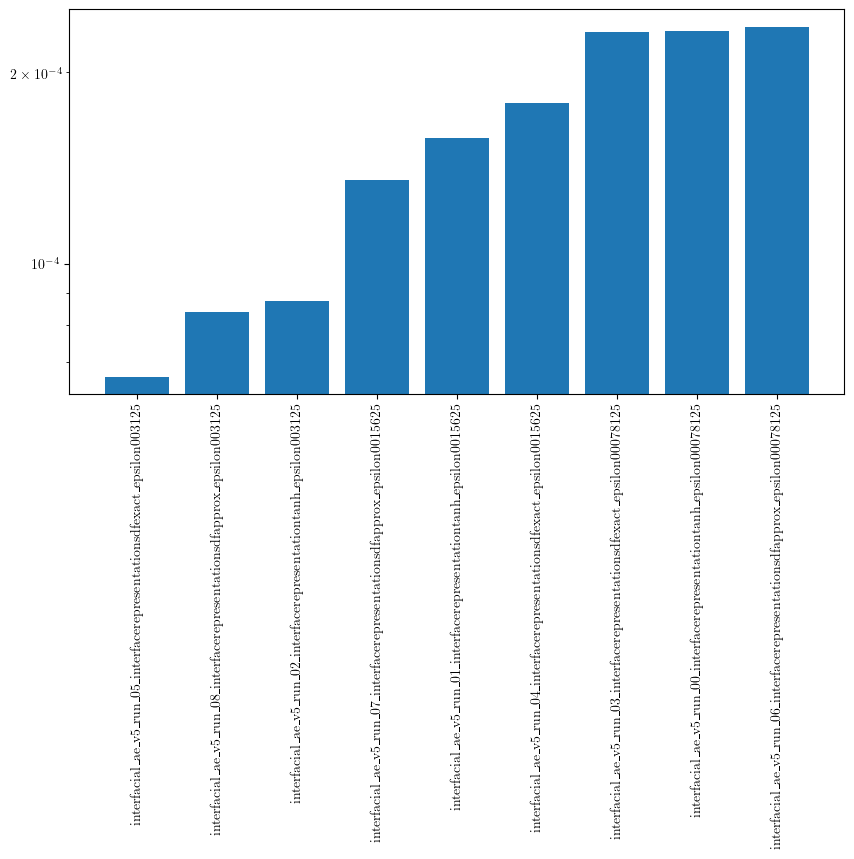

In [9]:


def read_metric_val(outdir):
    metric_paths = list(outdir.glob('metrics/val_metrics_*.csv'))
    metric_paths.sort(key=lambda x: int(x.stem.split('_')[-1]))
    metric_path = metric_paths[-1]
    
    print(f'Reading {metric_path}')
    
    df = pd.read_csv(metric_path)
    df = df.mean()
    return df['MSE']

name_to_val = {}
for f in sorted(files):
    try:
        name_to_val[f.name] = read_metric_val(f)
    except:
        print(f'Error reading {f.name}')
        
xs = name_to_val.keys()
ys = name_to_val.values()

# Sort by value
name_to_val = dict(sorted(name_to_val.items(), key=lambda x: x[1]))

plt.figure(figsize=(10, 5))
plt.bar(name_to_val.keys(), name_to_val.values())
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()


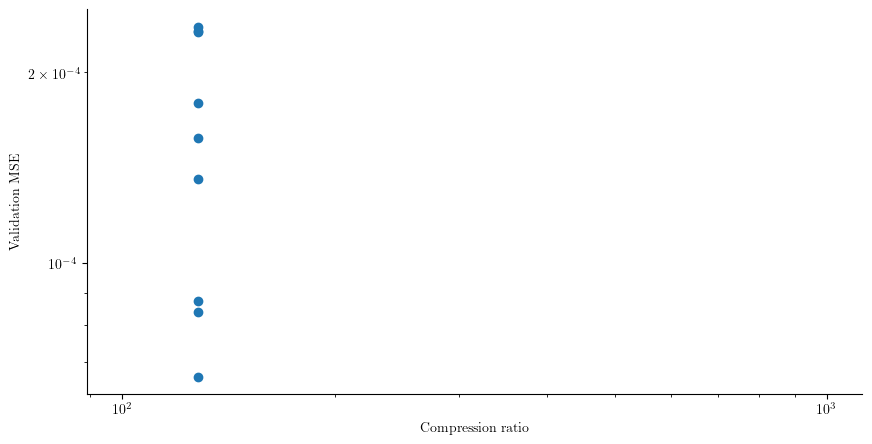

In [10]:
crs = []
for name in name_to_val.keys():
    crs.append(name_to_compression_ratio[name])
    
# Scatter compression ratio vs validation MSE
plt.figure(figsize=(10, 5))
plt.scatter(crs, name_to_val.values())
plt.xlabel('Compression ratio')
plt.ylabel('Validation MSE')
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [11]:

def image_path(outdir, i = 0):
    return outdir / 'final_val_samples_unnormalised' / f'final_{i}_slice.png'


In [15]:
import math

# Create single plot comparing all the final validation images, no osrting

def reconstructed_image_comparison_plot(val_ind: int = 0):
    
    im_paths = []
    for f in files:
        im_path = image_path(f, val_ind)
        if im_path.exists():
            im_paths.append(im_path)

    plt.figure(figsize=(20, 20))
    ims_per_row = 4
    num_ims = len(im_paths)
    num_rows = math.ceil(num_ims / ims_per_row)
    
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows), dpi=200)
    
    for i, im_path in enumerate(im_paths):
        im = plt.imread(im_path)#[800:, :800]
        row = i // ims_per_row
        col = i % ims_per_row
        axs[row, col].imshow(im)
        axs[row, col].axis('off')
        axs[row, col].set_title(im_path.parent.parent.name)
    
    fig.tight_layout()
    plt.show()


<Figure size 2000x2000 with 0 Axes>

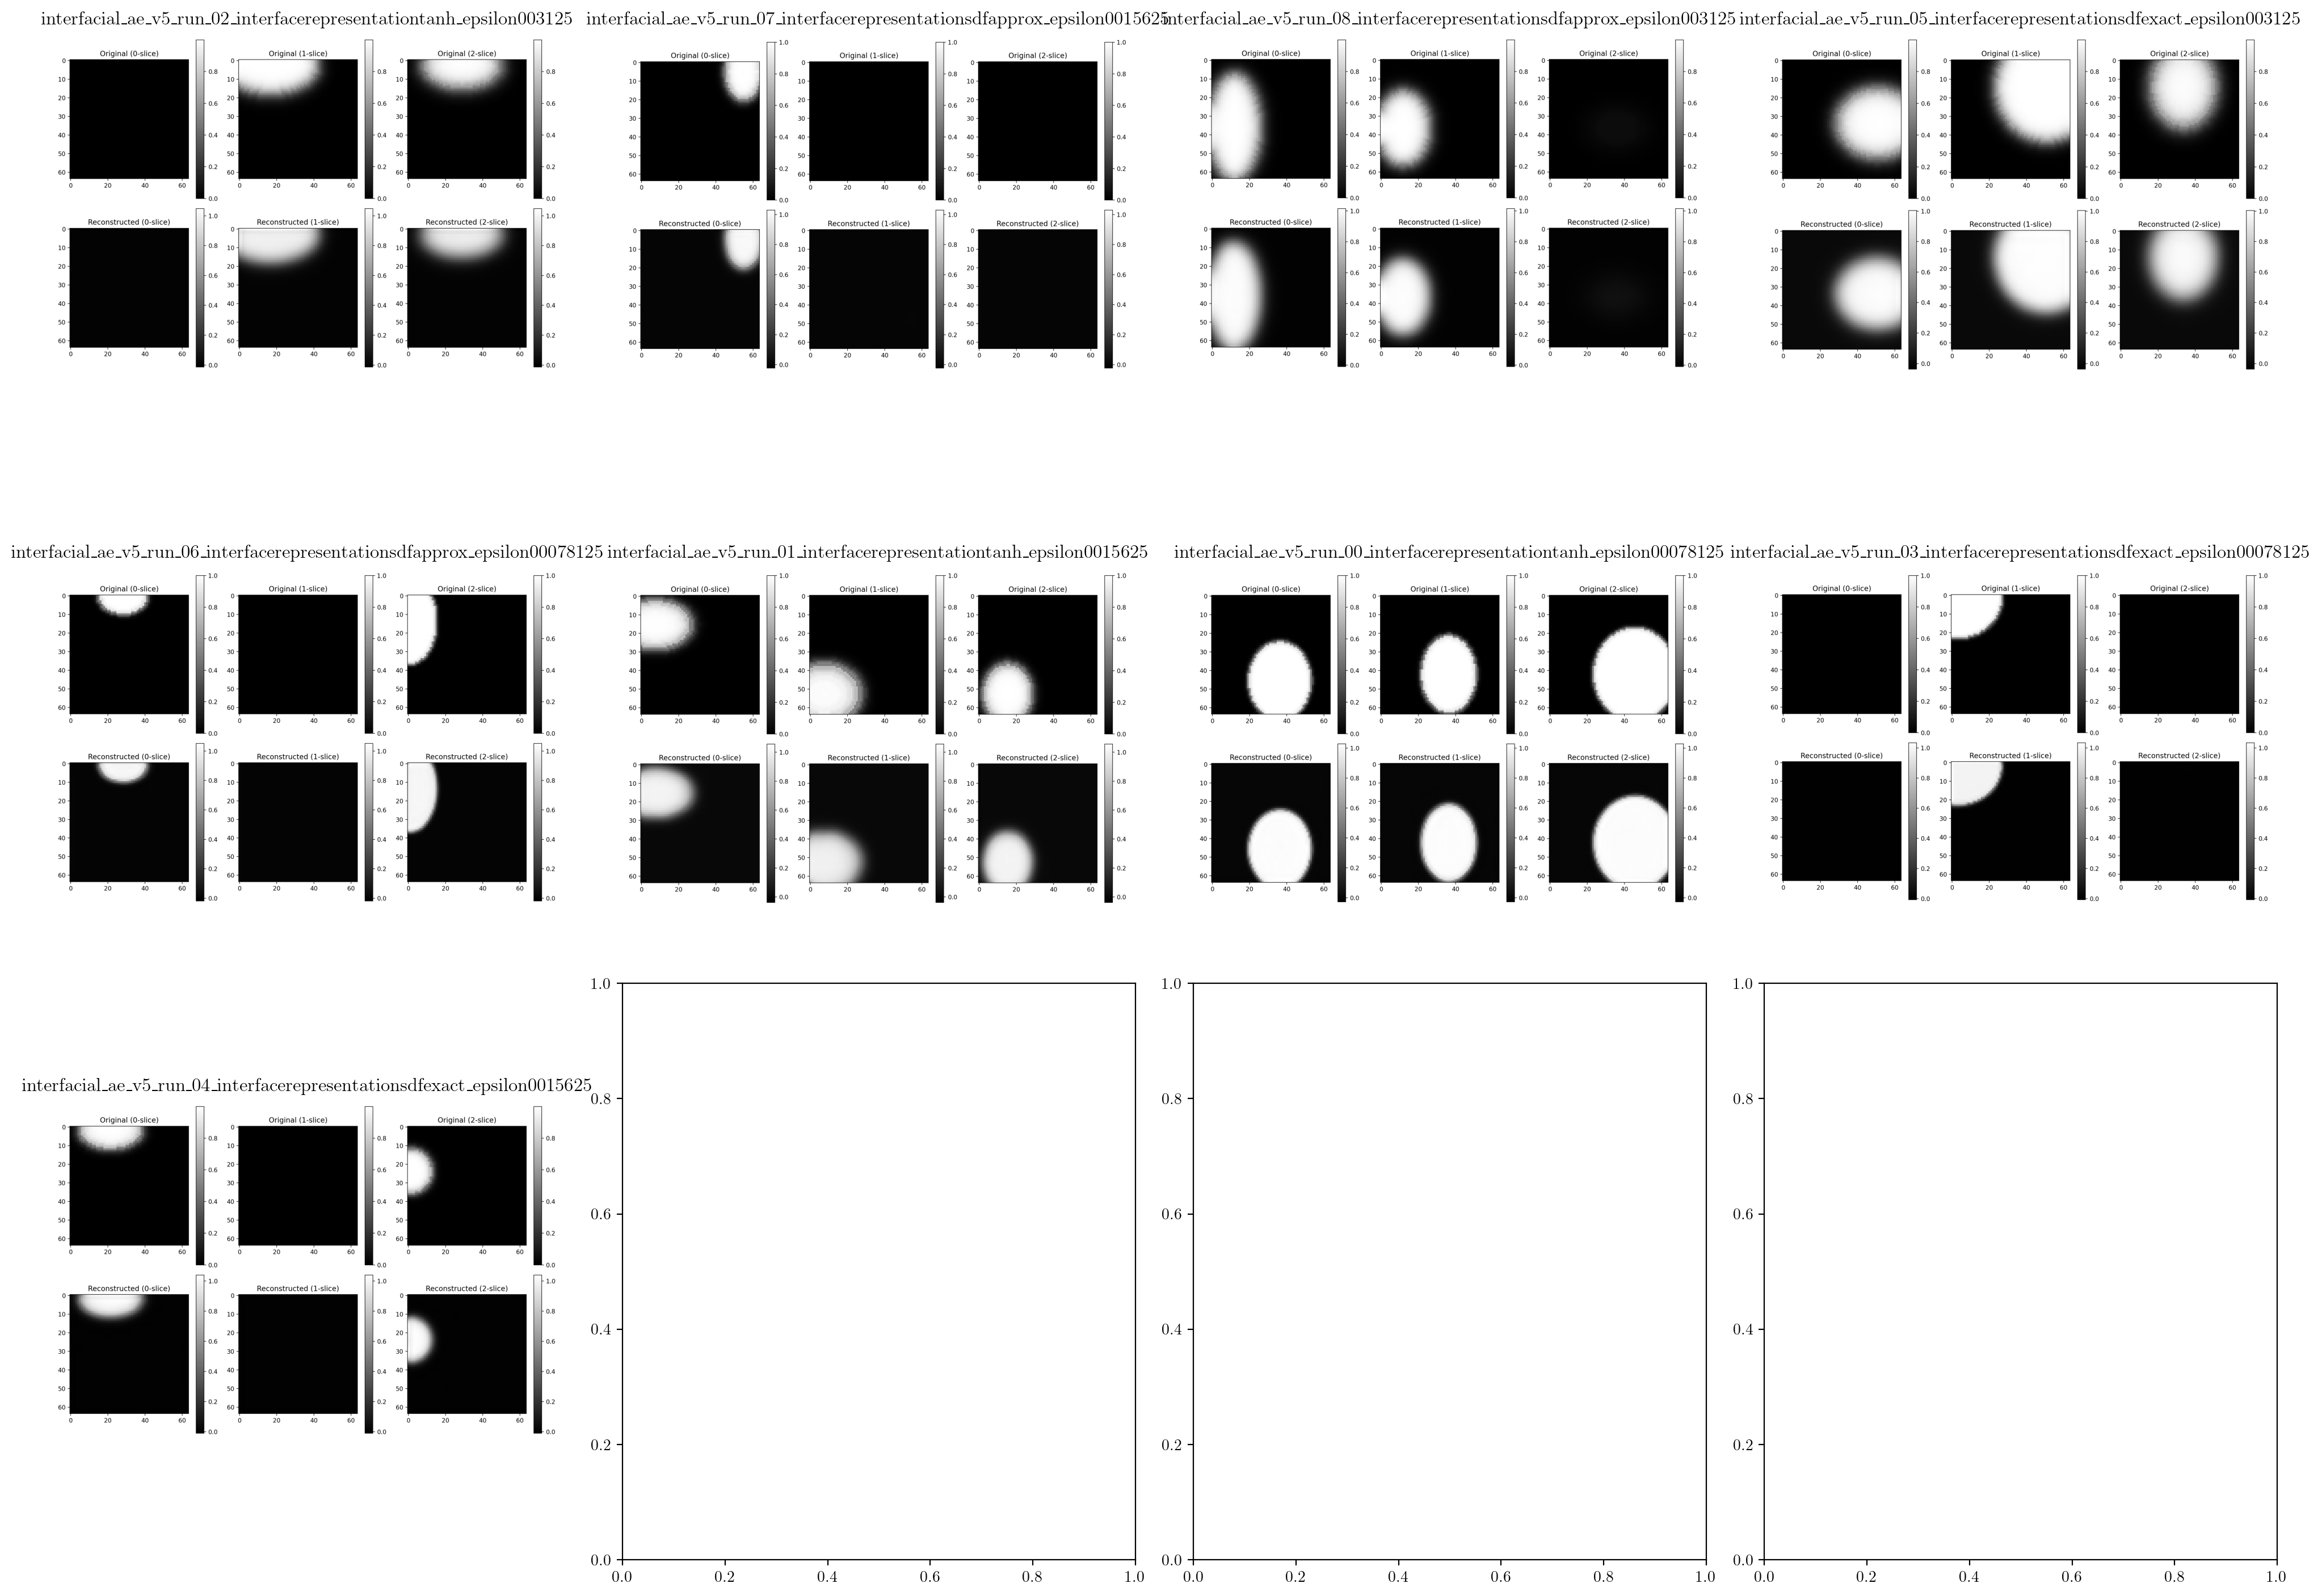

In [16]:
reconstructed_image_comparison_plot(0)

<Figure size 2000x2000 with 0 Axes>

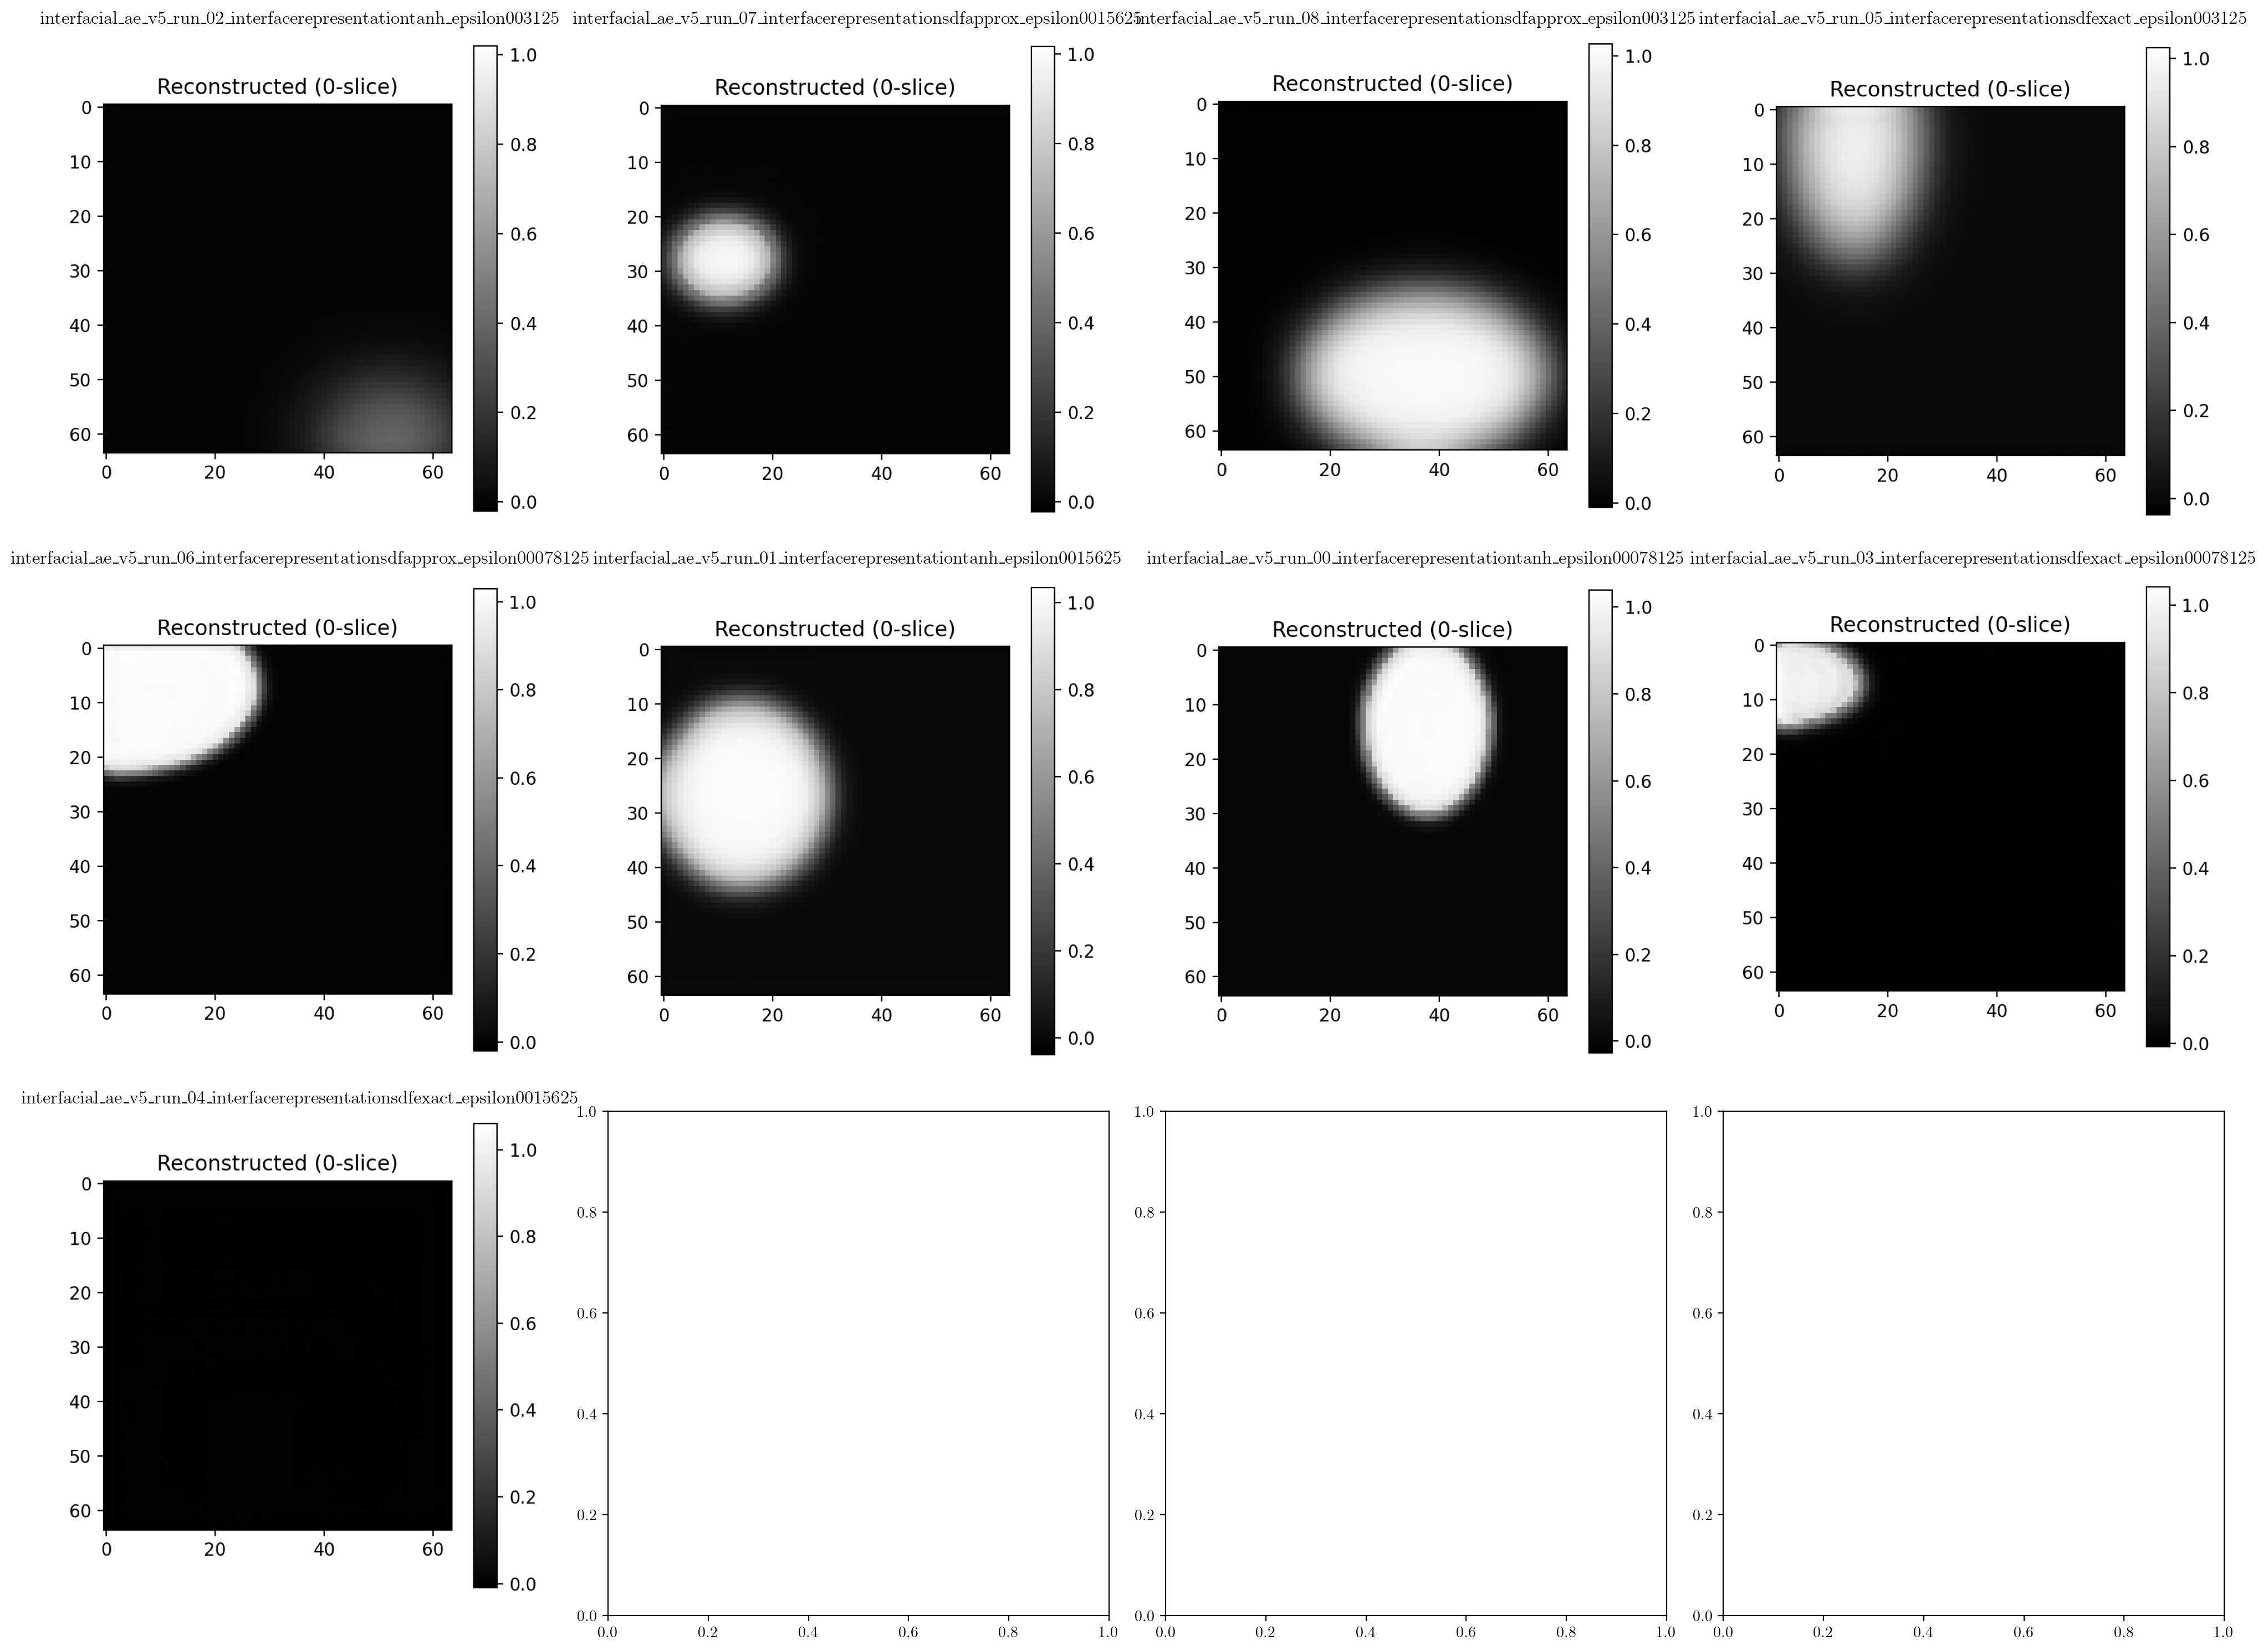

In [14]:
reconstructed_image_comparison_plot(1)

In [ ]:
reconstructed_image_comparison_plot(7)

In [ ]:
# Show some of the png images in the final_val_samples_unnormalised folder for each run so we can compare side by side



for f in files:
    print(f.name)
    
    im_path = image_path(f)
    
    if im_path.exists():
        im = plt.imread(im_path)
        plt.figure(figsize=(8, 8), dpi=200)
        plt.imshow(im)
        plt.axis('off')
        plt.show()
        plt.close()

